In [1]:
!pip install resampy
!pip install git+https://github.com/qubvel/classification_models.git
!pip install keras-radam
!pip install adabelief-tf==0.1.0
!pip install keras-rectified-adam
!pip install keras-adabound
!pip install git+https://github.com/tensorflow/addons

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-aolqnad_
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-aolqnad_
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/tensorflow/addons to /tmp/pip-req-build-be8011sg
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/addons /tmp/pip-req-build-be8011sg
  Resolved https://github.com/tensorflow/addons to commit 5dd5f65827c37e9b9b616b79ed93da856b57ffe5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense , Activation , Dropout , SpatialDropout2D, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, ReLU, Flatten
from keras.optimizers import Adam

from keras import backend as keras_backend
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from adabelief_tf import AdaBeliefOptimizer
from keras_radam.training import RAdamOptimizer
from keras_adabound import AdaBound
import tensorflow_addons
from keras.layers import LSTM,Input

import seaborn as sns
import random
import math

from glob import glob
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [4]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')

In [5]:
def get_duration(file_name):

    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    time = librosa.get_duration(y=audio, sr=sample_rate)

    return time

In [6]:
duration = []

for index_num, row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    time = get_duration(file_name)

    duration.append(time)

3480it [01:37, 35.76it/s]


In [7]:
df['duration'] = duration
sorted_df = df[df.duration <= 3]
sorted_df['class'].value_counts()

Grunt    1491
Roar      993
IRoar     987
Name: class, dtype: int64

In [8]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [9]:
appended = []
for i in range(1,4):
    appended.append(sorted_df[sorted_df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Grunt,Roar,IRoar
0,fold1,496,332,326
1,fold2,496,329,329
2,fold3,499,332,332


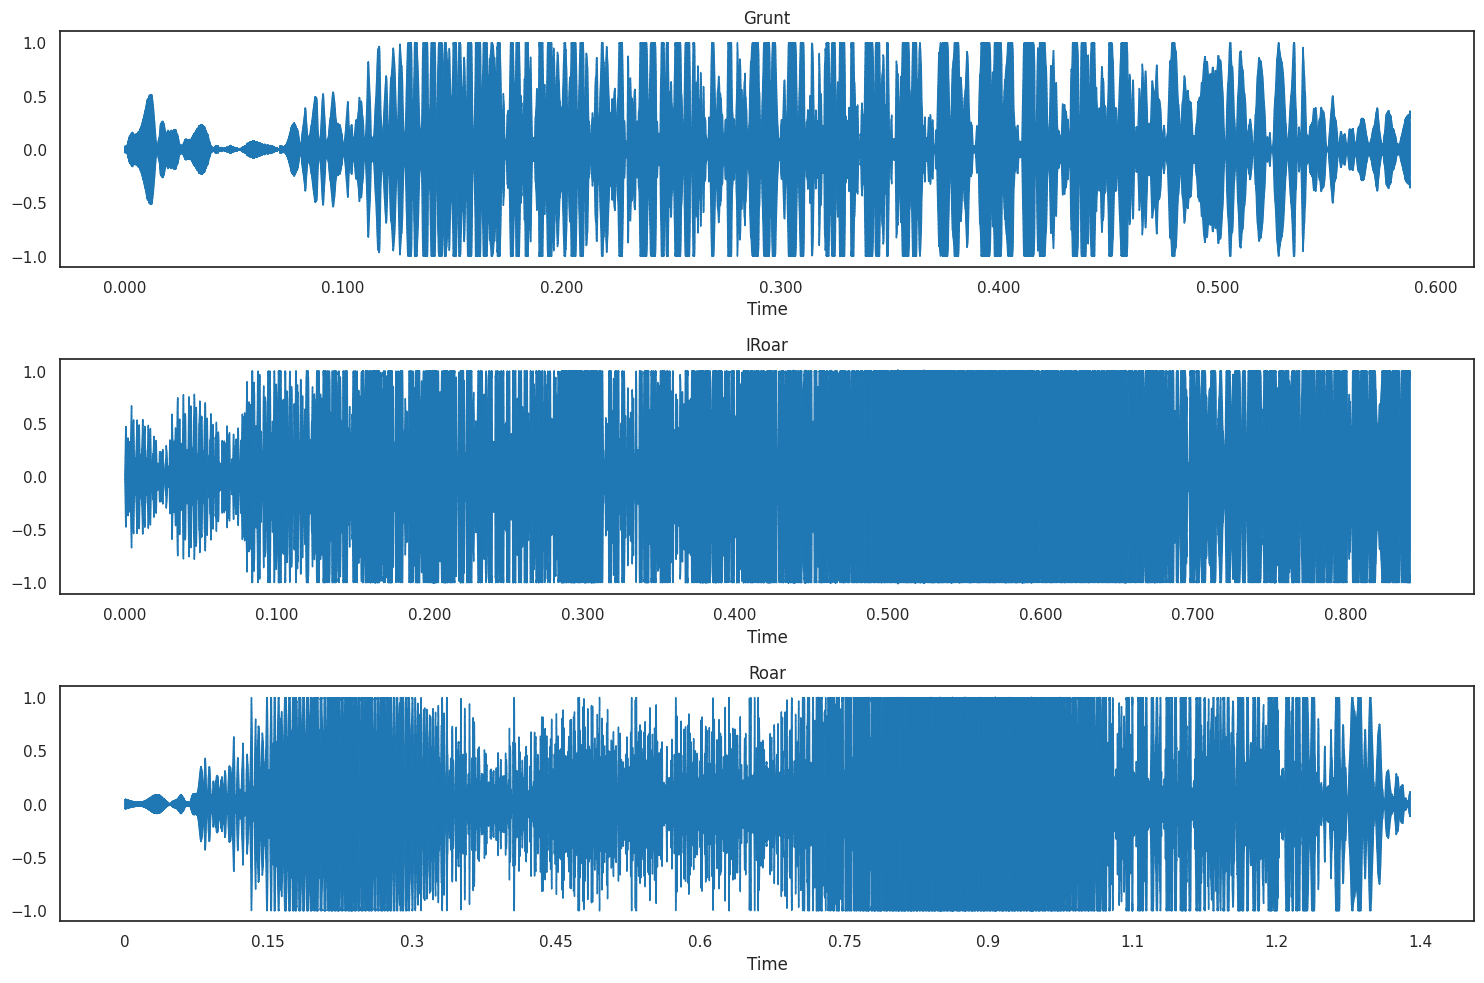

In [10]:
# Randomly select one sample of each class
random_samples = sorted_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

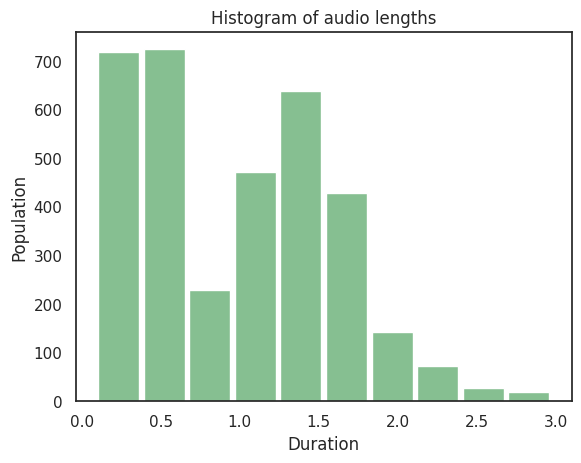

Greater than 3 seconds: 0
Lower than 3 but greater than 2 seconds: 152
Lower than 2 but greater than 1 seconds: 1601
Lower than 1 seconds: 1718


In [11]:
plt.hist(sorted_df['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = sorted_df['duration'][(sorted_df['duration'] > 3)].count()
gt_2sec = sorted_df['duration'][(sorted_df['duration'] > 2) & (sorted_df['duration'] < 3)].count()
lt_2sec = sorted_df['duration'][(sorted_df['duration'] > 1) & (sorted_df['duration'] < 2)].count()
lt_1sec = sorted_df['duration'][sorted_df['duration'] < 1].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 but greater than 2 seconds: {}".format(gt_2sec))
print("Lower than 2 but greater than 1 seconds: {}".format(lt_2sec))
print("Lower than 1 seconds: {}".format(lt_1sec))

In [12]:
# Feature extraction using librosa

x_train=[]
x_test=[]
y_train=[]
y_test=[]

path='/content/drive/MyDrive/ThesisData/File'
for i in tqdm(range(len(df))):
    fold_no=str(df.iloc[i]["fold"])
    file=df.iloc[i]["slice_file_name"]
    label=df.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename, res_type='kaiser_fast')
    #trim the audio file
    y_trimmed, _ = librosa.effects.trim(y)
    mfccs = np.mean(librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=40).T,axis=0)
    if(fold_no!='3'):
      x_train.append(mfccs)
      y_train.append(label)
    else:
      x_test.append(mfccs)
      y_test.append(label)

  5%|▌         | 175/3480 [00:10<02:18, 23.79it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1999
  warnings.warn(
100%|██████████| 3480/3480 [03:00<00:00, 19.32it/s]


In [13]:
x=x_train+x_test
y=y_train+y_test

In [14]:
x=np.array(x)
y=np.array(y)
x.shape,y.shape

((3480, 40), (3480,))

In [15]:
#saving the data numpy arrays
np.savetxt("x.csv", x, delimiter=",")
np.savetxt("y.csv",y,delimiter=",")

In [16]:
import math

indexes = []
total = len(df)
indexes = list(range(0, total))
# Randomize indexes random.shuffle(indexes)
# Divide the indexes into Train and Test
test_split_pct = 30
split_offset = math.floor(test_split_pct * total / 100)
# Split the data
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]
# Split the features with the same indexes
X_test = np.take(x, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(x, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)
# Also split metadata
test = df.iloc[test_split_idx]
train = df.iloc[train_split_idx]
# Print status
print("Test split: {} \t\t Train split: {}".format(len(test), len(train)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1044 		 Train split: 2436
X test shape: (1044, 40) 	 X train shape: (2436, 40)
y test shape: (1044,) 		 y train shape: (2436,)


In [17]:
#converting to one hot
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
y_train.shape,y_test.shape

((2436, 3), (1044, 3))

In [18]:
#reshaping to 2D
X_train=np.reshape(X_train,(X_train.shape[0], 1,40))
X_test=np.reshape(X_test,(X_test.shape[0], 1,40))
X_train.shape,X_test.shape

((2436, 1, 40), (1044, 1, 40))

In [19]:
#reshaping to 2D
y_train=np.reshape(y_train,(y_train.shape[0], 1,3))
y_test=np.reshape(y_test,(y_test.shape[0], 1,3))
y_train.shape,y_test.shape

((2436, 1, 3), (1044, 1, 3))

In [20]:
from keras.layers import LSTM,Input

# Model
model = Sequential()
model.add(LSTM(40,input_shape=(1,40), return_sequences=True))
model.add(LSTM(40,input_shape=(1,40),return_sequences=True))
model.add(Dense(512,activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation ='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 40)             12960     
                                                                 
 lstm_1 (LSTM)               (None, 1, 40)             12960     
                                                                 
 dense (Dense)               (None, 1, 512)            20992     
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 dense_1 (Dense)             (None, 1, 3)              1539      
                                                                 
Total params: 48,451
Trainable params: 48,451
Non-trainable params: 0
_________________________________________________________________


In [21]:
from tensorflow import keras

In [22]:
k = []
ok = 0
yes = 0
zet = 0
yep = 0


opt =  [keras.optimizers.Adam(learning_rate=0.001),
                  keras.optimizers.SGD(learning_rate=0.01),
                  keras.optimizers.Nadam(learning_rate=0.001),
                  keras.optimizers.RMSprop(learning_rate=0.001),
                  RAdamOptimizer(learning_rate=0.001),
                  tensorflow_addons.optimizers.yogi.Yogi(learning_rate=0.001)]

for t in opt:
    del model
    #del base_model
    #del x
    #del output
    if (t == opt[0]):
        print("-------------------------------------optimizer = Adam-------------------------------------")
    elif (t == opt[1]):
            print("-------------------------------------optimizer = SGD-------------------------------------")
    elif (t == opt[2]):
            print("-------------------------------------optimizer = Nadam-------------------------------------")
    elif (t == opt[3]):
            print("-------------------------------------optimizer = RMSprop-------------------------------------")
    elif (t == opt[4]):
            print("-------------------------------------optimizer = RAdam-------------------------------------")

    elif (t == opt[5]):
            print("-------------------------------------optimizer = Yogi-------------------------------------")

    model = Sequential()
    model.add(LSTM(40,input_shape=(1,40), return_sequences=True))
    model.add(LSTM(40,input_shape=(1,40),return_sequences=True))
    model.add(Dense(512,activation ='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3,activation ='softmax'))
    # 8. Compile model
    model.compile(loss='categorical_crossentropy',
              optimizer = t,
              metrics=['accuracy'])


       # 9. Fit model on training data
    k.append(model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test),verbose=1))

-------------------------------------optimizer = Adam-------------------------------------
Epoch 1/100
77/77 [==============================] - 8s 37ms/step - loss: 0.7354 - accuracy: 0.6634 - val_loss: 0.4532 - val_accuracy: 0.7979
Epoch 2/100
77/77 [==============================] - 1s 15ms/step - loss: 0.4281 - accuracy: 0.8313 - val_loss: 0.4439 - val_accuracy: 0.8113
Epoch 3/100
77/77 [==============================] - 1s 10ms/step - loss: 0.3939 - accuracy: 0.8420 - val_loss: 0.4287 - val_accuracy: 0.8094
Epoch 4/100
77/77 [==============================] - 1s 9ms/step - loss: 0.3728 - accuracy: 0.8592 - val_loss: 0.4096 - val_accuracy: 0.8190
Epoch 5/100
77/77 [==============================] - 1s 11ms/step - loss: 0.3540 - accuracy: 0.8629 - val_loss: 0.4108 - val_accuracy: 0.8247
Epoch 6/100
77/77 [==============================] - 1s 11ms/step - loss: 0.3440 - accuracy: 0.8604 - val_loss: 0.4038 - val_accuracy: 0.8247
Epoch 7/100
77/77 [==============================] - 1s 9m

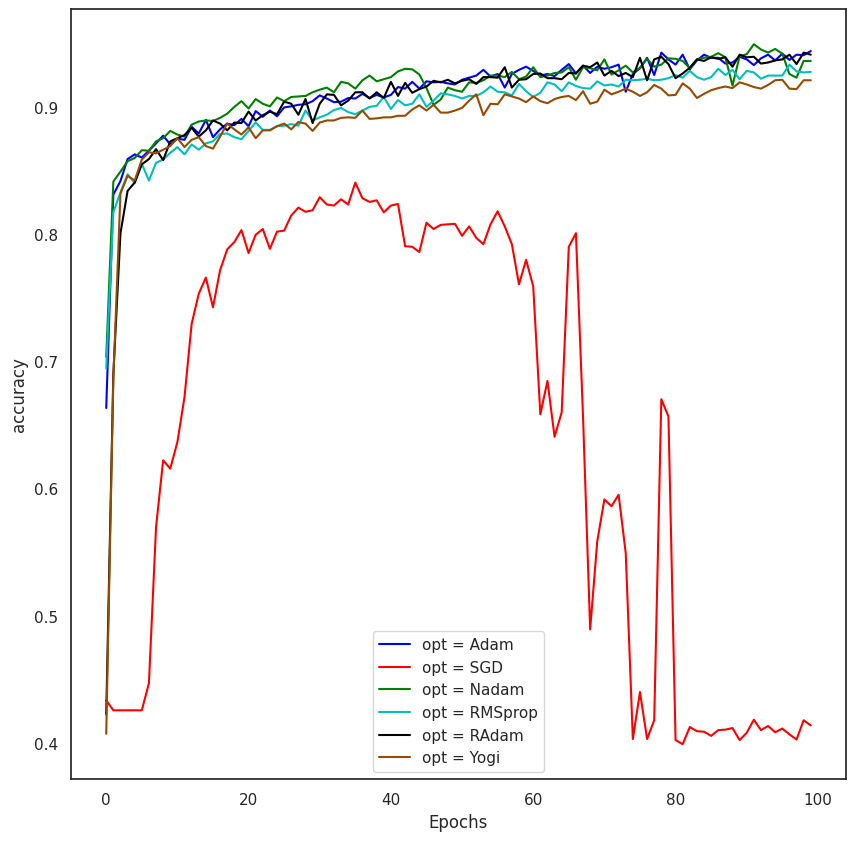

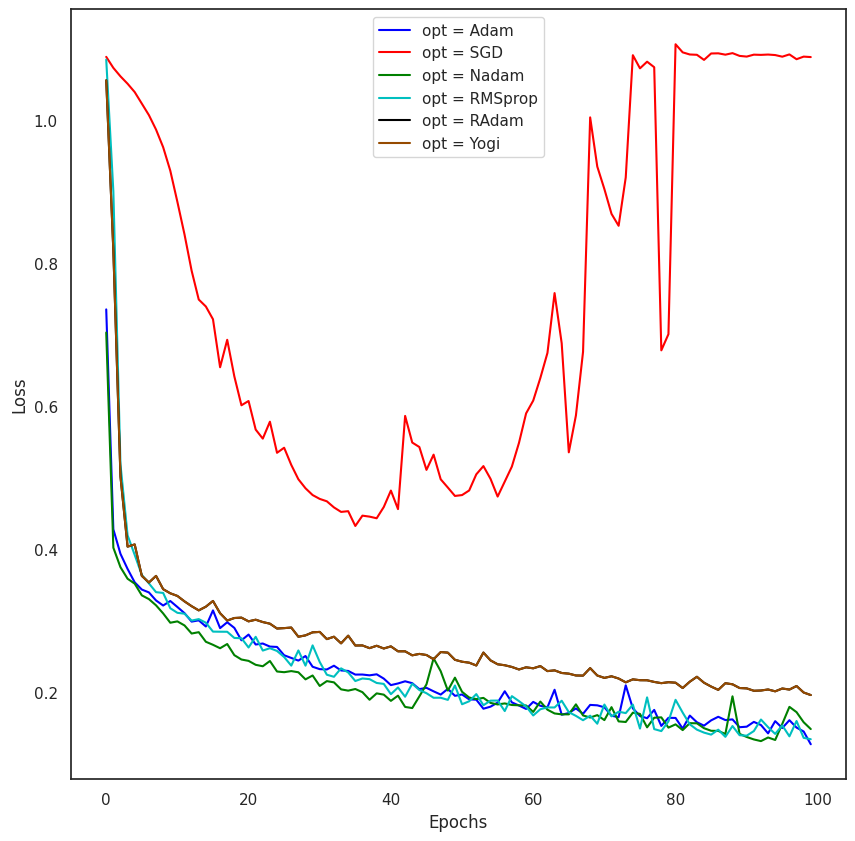

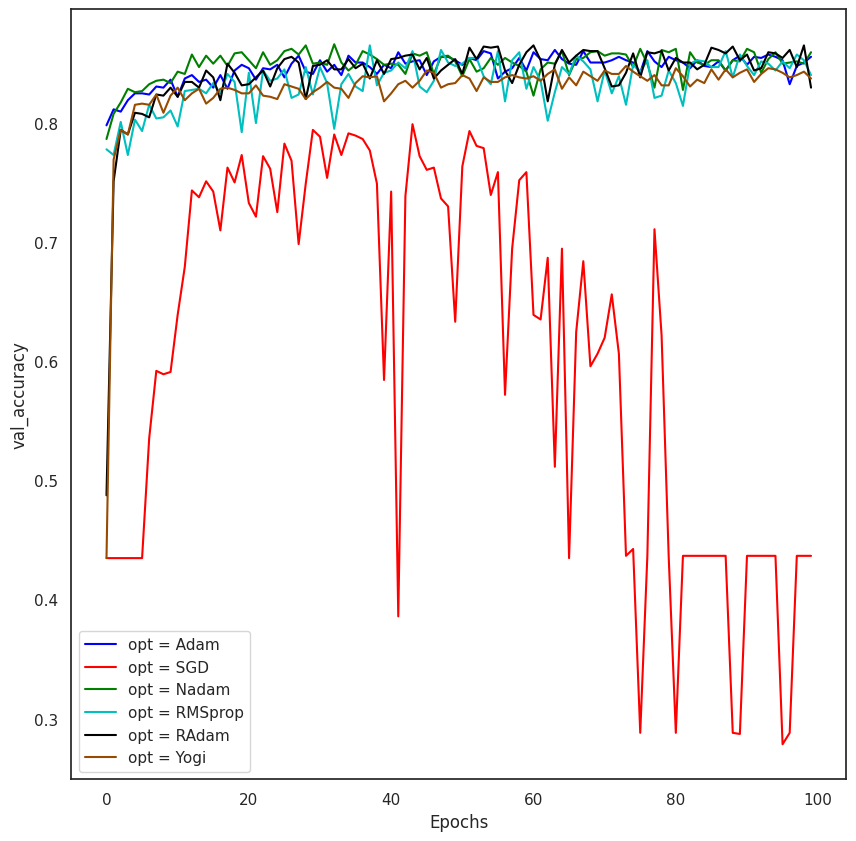

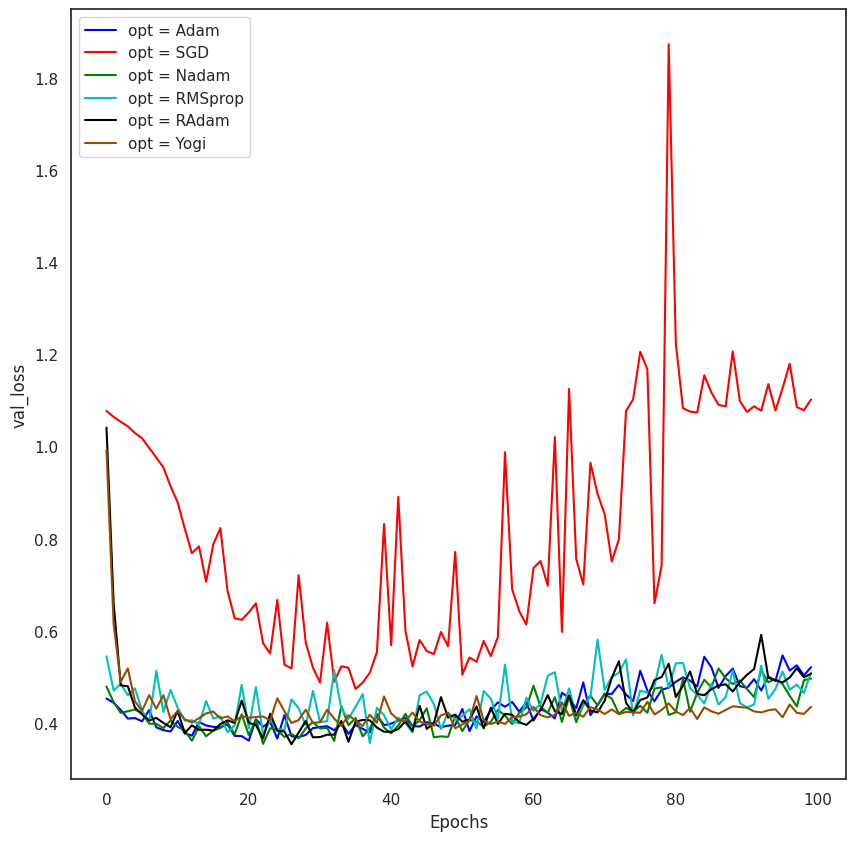

In [23]:
while (ok<len(k)):



    plt.figure(figsize=(10,10))
    plt.plot(k[ok+0].history['accuracy'],color='b', label="opt = Adam")
    plt.plot(k[ok+1].history['accuracy'],color='r', label="opt = SGD")
    plt.plot(k[ok+2].history['accuracy'],color='g', label="opt = Nadam")
    plt.plot(k[ok+3].history['accuracy'],color='c', label="opt = RMSprop")
    plt.plot(k[ok+4].history['accuracy'],color='k', label="opt = RAdam")
    plt.plot(k[ok+5].history['accuracy'],color='#964B00', label="opt = Yogi")

    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    ok +=6







while (yes<len(k)):



    plt.figure(figsize=(10,10))
    plt.plot(k[yes+0].history['loss'],color='b', label="opt = Adam")
    plt.plot(k[yes+1].history['loss'],color='r', label="opt = SGD")
    plt.plot(k[yes+2].history['loss'],color='g', label="opt = Nadam")
    plt.plot(k[yes+4].history['loss'],color='c', label="opt = RMSprop")
    plt.plot(k[yes+5].history['loss'],color='k', label="opt = RAdam")
    plt.plot(k[yes+5].history['loss'],color='#964B00', label="opt = Yogi")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    yes+=6




while (zet<len(k)):



    plt.figure(figsize=(10,10))
    plt.plot(k[zet+0].history['val_accuracy'],color='b', label="opt = Adam")
    plt.plot(k[zet+1].history['val_accuracy'],color='r', label="opt = SGD")
    plt.plot(k[zet+2].history['val_accuracy'],color='g', label="opt = Nadam")
    plt.plot(k[zet+3].history['val_accuracy'],color='c', label="opt = RMSprop")
    plt.plot(k[zet+4].history['val_accuracy'],color='k', label="opt = RAdam")
    plt.plot(k[zet+5].history['val_accuracy'],color='#964B00', label="opt = Yogi")

    plt.xlabel('Epochs')
    plt.ylabel('val_accuracy')
    plt.legend()
    plt.show()

    zet+=6





while (yep<len(k)):



    plt.figure(figsize=(10,10))
    plt.plot(k[yep+0].history['val_loss'],color='b', label="opt = Adam")
    plt.plot(k[yep+1].history['val_loss'],color='r', label="opt = SGD")
    plt.plot(k[yep+2].history['val_loss'],color='g', label="opt = Nadam")
    plt.plot(k[yep+3].history['val_loss'],color='c', label="opt = RMSprop")
    plt.plot(k[yep+4].history['val_loss'],color='k', label="opt = RAdam")
    plt.plot(k[yep+5].history['val_loss'],color='#964B00', label="opt = Yogi")

    plt.xlabel('Epochs')
    plt.ylabel('val_loss')
    plt.legend()
    plt.show()

    yep+=6

In [24]:
#train and test loss and scores respectively
train_loss_score=model.evaluate(X_train,y_train)
test_loss_score=model.evaluate(X_test,y_test)
print(train_loss_score)
print(test_loss_score)

33/33 [==============================] - 0s 5ms/step - loss: 0.4351 - accuracy: 0.8372
[0.18888473510742188, 0.9236453175544739]
[0.43510201573371887, 0.8371647596359253]


In [25]:
# Predict probabilities for test set
y_probs = model.predict(X_test)
# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)

33/33 [==============================] - 1s 3ms/step
